In this notebook, I use the National Park API to pull in topics and activities related to each national park to build a topic/activity matrix for my recommender. I also scrape the National Park website for visitor count information.

# Table of Contents
1. [Imports](#section1)
2. [Sign in to API](#section2)
3. [API Exploration Functions](#section3)
4. [Collect National Park Names](#section4)


Exploration Part of the Notebook:<br/>
5. [Practice Parsing through an HTML table](#section5)<br/>
6. [More EDA](#section6)<br/>

<a id='section1'></a>

### 1. Imports

In [476]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

%matplotlib inline

In [85]:
# API access imports
import requests
import json

# web scraping
from bs4 import BeautifulSoup
import time
import re

In [213]:
# use cosine similarity to use as a topic/activity matrix recommender
from sklearn.metrics.pairwise import cosine_similarity

<a id='section2'></a>

### 2. Sign in to API

In [86]:
# fill in with own API key
api_key = ''

In [87]:
endpoint = 'https://developer.nps.gov/api/v1'
HEADERS = {"api_key": api_key}

<a id='section3'></a>

### 3. API Exploration Functions

In [88]:
def build_url(endpoint, search_type, parks):
    '''
    This function is used to access different National Park API endpoints.
    Parameters:
    -----------
    - endpoint: one of the National Park endpoints such as activities. Endpoints can be found 
    at this website https://www.nps.gov/subjects/developer/api-documentation.htm#/
    - search_type: some endpoints have multiple search types
    - parks: list of 4 letter park codes
    
    Returns:
    --------
    - final_url: final url combining the endpoint, search type, and parks
    '''
    final_url = endpoint + "/" + search_type
    for park in parks:
        final_url = final_url + "?parkCode=" + park
    return final_url

In [90]:
def get_json(api_url, HEADERS):
    '''
    This function is access a JSON object from an API endpoint.
    Parameters:
    -----------
    - api_url: API endpoint URL
    - HEADERS: API access credentials
    
    Returns:
    --------
    - json object related to the API call
    
    '''
    try:
        response = requests.get(api_url, params=HEADERS)
    except requests.exceptions.ConnectionError as e:
        raise RuntimeError(e)
    return response.json()

<a id='section4'></a>

### 4. Collecting National Park Names

In [15]:
url = 'https://irma.nps.gov/RPRS/Parks/Search'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')
soup

Copy and paste the park 4 letter codes and the names associated with them.

In [51]:
park_names = [{"Key":"ABLI","Value":"Abraham Lincoln Birthplace (ABLI)"},{"Key":"ACAD","Value":"Acadia (ACAD)"},{"Key":"ADAM","Value":"Adams (ADAM)"},{"Key":"AFBG","Value":"African Burial Ground (AFBG)"},{"Key":"AGFO","Value":"Agate Fossil Beds (AGFO)"},{"Key":"ALKA","Value":"Ala Kahakai National Historic Trail (ALKA)"},{"Key":"ALAG","Value":"Alagnak Wild River (ALAG)"},{"Key":"ALEU","Value":"Aleutian Islands World War II (ALEU)"},{"Key":"ALFL","Value":"Alibates Flint Quarries (ALFL)"},{"Key":"ALPO","Value":"Allegheny Portage Railroad (ALPO)"},{"Key":"AMME","Value":"American Memorial Park (AMME)"},{"Key":"AMIS","Value":"Amistad (AMIS)"},{"Key":"ANDE","Value":"Andersonville (ANDE)"},{"Key":"ANJO","Value":"Andrew Johnson (ANJO)"},{"Key":"ANIA","Value":"Aniakchak (ANIA)"},{"Key":"ANTI","Value":"Antietam (ANTI)"},{"Key":"ANCM","Value":"Antietam (ANCM)"},{"Key":"APIS","Value":"Apostle Islands (APIS)"},{"Key":"APPA","Value":"Appalachian (APPA)"},{"Key":"APCO","Value":"Appomattox Court House (APCO)"},{"Key":"ARCH","Value":"Arches (ARCH)"},{"Key":"ARPO","Value":"Arkansas Post (ARPO)"},{"Key":"ARHO","Value":"Arlington House, The Robert E. Lee Memorial (ARHO)"},{"Key":"ASIS","Value":"Assateague Island (ASIS)"},{"Key":"AZRU","Value":"Aztec Ruins (AZRU)"},{"Key":"BADL","Value":"Badlands (BADL)"},{"Key":"BAWA","Value":"Baltimore-Washington (BAWA)"},{"Key":"BAND","Value":"Bandelier (BAND)"},{"Key":"BATT","Value":"Battleground (BATT)"},{"Key":"BEPA","Value":"Belmont-Paul Women's Equality (BEPA)"},{"Key":"BEFR","Value":"Benjamin Franklin National Memorial (BEFR)"},{"Key":"BEOL","Value":"Bent's Old Fort (BEOL)"},{"Key":"BELA","Value":"Bering Land Bridge (BELA)"},{"Key":"BERI","Value":"Beringia International Heritage Park (BERI)"},{"Key":"BIBE","Value":"Big Bend (BIBE)"},{"Key":"BICY","Value":"Big Cypress (BICY)"},{"Key":"BIHO","Value":"Big Hole (BIHO)"},{"Key":"BISO","Value":"Big South Fork National River and Recreation Area (BISO)"},{"Key":"BITH","Value":"Big Thicket (BITH)"},{"Key":"BICA","Value":"Bighorn Canyon (BICA)"},{"Key":"BISC","Value":"Biscayne (BISC)"},{"Key":"BLCA","Value":"Black Canyon of the Gunnison (BLCA)"},{"Key":"BLRV","Value":"Blackstone River Valley (BLRV)"},{"Key":"BLAC","Value":"Blackstone River Valley National Heritage Corridor (BLAC)"},{"Key":"BLRI","Value":"Blue Ridge Parkway (BLRI)"},{"Key":"BLUE","Value":"Bluestone National Scenic River (BLUE)"},{"Key":"BOWA","Value":"Booker T. Washington (BOWA)"},{"Key":"BOST","Value":"Boston (BOST)"},{"Key":"BOAF","Value":"Boston African American (BOAF)"},{"Key":"BOHA","Value":"Boston Harbor Islands (BOHA)"},{"Key":"BRCR","Value":"Brices Cross Roads (BRCR)"},{"Key":"BRVB","Value":"Brown v. Board of Education (BRVB)"},{"Key":"BRCA","Value":"Bryce Canyon (BRCA)"},{"Key":"BUIS","Value":"Buck Island Reef (BUIS)"},{"Key":"BUFF","Value":"Buffalo (BUFF)"},{"Key":"CABR","Value":"Cabrillo (CABR)"},{"Key":"CALA","Value":"Cache La Poudre River Corridor (CALA)"},{"Key":"CALI","Value":"California (CALI)"},{"Key":"CANA","Value":"Canaveral (CANA)"},{"Key":"CRHA","Value":"Cane River (CRHA)"},{"Key":"CARI","Value":"Cane River Creole (CARI)"},{"Key":"CACH","Value":"Canyon De Chelly (CACH)"},{"Key":"CANY","Value":"Canyonlands (CANY)"},{"Key":"CACO","Value":"Cape Cod (CACO)"},{"Key":"CAHA","Value":"Cape Hatteras (CAHA)"},{"Key":"CAME","Value":"Cape Henry (CAME)"},{"Key":"CAKR","Value":"Cape Krusenstern (CAKR)"},{"Key":"CALO","Value":"Cape Lookout (CALO)"},{"Key":"CARE","Value":"Capitol Reef (CARE)"},{"Key":"CAJO","Value":"Captain John Smith Chesapeake National Historic Trail (CAJO)"},{"Key":"CAVO","Value":"Capulin Volcano (CAVO)"},{"Key":"CARL","Value":"Carl Sandburg Home (CARL)"},{"Key":"CAVE","Value":"Carlsbad Caverns (CAVE)"},{"Key":"CAGR","Value":"Casa Grande Ruins (CAGR)"},{"Key":"CASA","Value":"Castillo De San Marcos (CASA)"},{"Key":"CACL","Value":"Castle Clinton (CACL)"},{"Key":"CATO","Value":"Catoctin Mountain (CATO)"},{"Key":"CEBR","Value":"Cedar Breaks (CEBR)"},{"Key":"CEBE","Value":"Cedar Creek and Belle Grove (CEBE)"},{"Key":"CHSC","Value":"Central High School (CHSC)"},{"Key":"CECH","Value":"Cesar E. Chavez (CECH)"},{"Key":"CHCU","Value":"Chaco Culture (CHCU)"},{"Key":"CHAM","Value":"Chamizal (CHAM)"},{"Key":"CHIS","Value":"Channel Islands (CHIS)"},{"Key":"CHPI","Value":"Charles Pinckney (CHPI)"},{"Key":"CHYO","Value":"Charles Young Buffalo Soldiers (CHYO)"},{"Key":"CHAT","Value":"Chattahoochee River (CHAT)"},{"Key":"CHOH","Value":"Chesapeake and Ohio Canal (CHOH)"},{"Key":"CBPO","Value":"Chesapeake Bay Gateways (CBPO)"},{"Key":"CHPO","Value":"Chicago Portage National Historic Site (CHPO)"},{"Key":"CHCH","Value":"Chickamauga and Chattanooga (CHCH)"},{"Key":"CHIC","Value":"Chickasaw (CHIC)"},{"Key":"CHRO","Value":"Chimney Rock National Historic Site (CHRO)"},{"Key":"CHIR","Value":"Chiricahua (CHIR)"},{"Key":"CHRI","Value":"Christiansted (CHRI)"},{"Key":"CIRO","Value":"City Of Rocks (CIRO)"},{"Key":"CLBA","Value":"Clara Barton (CLBA)"},{"Key":"COLO","Value":"Colonial (COLO)"},{"Key":"COLP","Value":"Colonial Parkway (COLP)"},{"Key":"COLM","Value":"Colorado (COLM)"},{"Key":"CONG","Value":"Congaree (CONG)"},{"Key":"CORO","Value":"Coronado (CORO)"},{"Key":"CODA","Value":"Coulee Dam (CODA)"},{"Key":"COWP","Value":"Cowpens (COWP)"},{"Key":"CRLA","Value":"Crater Lake (CRLA)"},{"Key":"CRMO","Value":"Craters of the Moon (CRMO)"},{"Key":"CUGA","Value":"Cumberland Gap (CUGA)"},{"Key":"CUIS","Value":"Cumberland Island (CUIS)"},{"Key":"CURE","Value":"Curecanti (CURE)"},{"Key":"CUVA","Value":"Cuyahoga Valley (CUVA)"},{"Key":"DABE","Value":"David Berger National Memorial (DABE)"},{"Key":"DAAV","Value":"Dayton Aviation Heritage (DAAV)"},{"Key":"DEVA","Value":"Death Valley (DEVA)"},{"Key":"DELE","Value":"Delaware and Lehigh Navigation Canal National Heritage Corridor (DELE)"},{"Key":"DELA","Value":"Delaware National Scenic River (DELA)"},{"Key":"DEWA","Value":"Delaware Water Gap (DEWA)"},{"Key":"DENA","Value":"Denali (DENA)"},{"Key":"DESO","Value":"DeSoto (DESO)"},{"Key":"DEPO","Value":"Devils Postpile (DEPO)"},{"Key":"DETO","Value":"Devils Tower (DETO)"},{"Key":"DINO","Value":"Dinosaur (DINO)"},{"Key":"DRTO","Value":"Dry Tortugas (DRTO)"},{"Key":"EBLA","Value":"Ebey's Landing (EBLA)"},{"Key":"EDAL","Value":"Edgar Allan Poe (EDAL)"},{"Key":"EFMO","Value":"Effigy Mounds (EFMO)"},{"Key":"EISE","Value":"Eisenhower (EISE)"},{"Key":"ELTE","Value":"El Camino Real de los Tejas (ELTE)"},{"Key":"ELCA","Value":"El Camino Real de Tierra Adentro (ELCA)"},{"Key":"ELMA","Value":"El Malpais (ELMA)"},{"Key":"ELMO","Value":"El Morro (ELMO)"},{"Key":"ELRO","Value":"Eleanor Roosevelt (ELRO)"},{"Key":"ELIS","Value":"Ellis Island (ELIS)"},{"Key":"ERIE","Value":"Erie Canalway (ERIE)"},{"Key":"ESSE","Value":"Essex (ESSE)"},{"Key":"EUON","Value":"Eugene O'Neill (EUON)"},{"Key":"EVER","Value":"Everglades (EVER)"},{"Key":"FATI","Value":"Fallen Timbers Battlefield (FATI)"},{"Key":"FARM","Value":"Farmington (FARM)"},{"Key":"FAMA","Value":"Father Marquette National Memorial (FAMA)"},{"Key":"FEHA","Value":"Federal Hall (FEHA)"},{"Key":"FIIS","Value":"Fire Island (FIIS)"},{"Key":"FILA","Value":"First Ladies (FILA)"},{"Key":"FRST","Value":"First State (FRST)"},{"Key":"FLNI","Value":"Flight 93 (FLNI)"},{"Key":"FLFO","Value":"Florissant Fossil Beds (FLFO)"},{"Key":"FOBO","Value":"Fort Bowie (FOBO)"},{"Key":"FODA","Value":"Fort Davis (FODA)"},{"Key":"FODO","Value":"Fort Donelson (FODO)"},{"Key":"FDNC","Value":"Fort Donelson (FDNC)"},{"Key":"FOFO","Value":"Fort Foote Park (FOFO)"},{"Key":"FOFR","Value":"Fort Frederica (FOFR)"},{"Key":"FOLA","Value":"Fort Laramie (FOLA)"},{"Key":"FOLS","Value":"Fort Larned (FOLS)"},{"Key":"FOMA","Value":"Fort Matanzas (FOMA)"},{"Key":"FOMC","Value":"Fort McHenry (FOMC)"},{"Key":"FOMR","Value":"Fort Monroe (FOMR)"},{"Key":"FONE","Value":"Fort Necessity (FONE)"},{"Key":"FOPO","Value":"Fort Point (FOPO)"},{"Key":"FOPU","Value":"Fort Pulaski (FOPU)"},{"Key":"FORA","Value":"Fort Raleigh (FORA)"},{"Key":"FOSC","Value":"Fort Scott (FOSC)"},{"Key":"FOSM","Value":"Fort Smith (FOSM)"},{"Key":"FOST","Value":"Fort Stanwix (FOST)"},{"Key":"FOSU","Value":"Fort Sumter (FOSU)"},{"Key":"FOUN","Value":"Fort Union (FOUN)"},{"Key":"FOUS","Value":"Fort Union Trading Post (FOUS)"},{"Key":"FOVA","Value":"Fort Vancouver (FOVA)"},{"Key":"FOWA","Value":"Fort Washington (FOWA)"},{"Key":"FOBU","Value":"Fossil Butte (FOBU)"},{"Key":"FRSC","Value":"Francis Scott Key (FRSC)"},{"Key":"FRDO","Value":"Frederick Douglass (FRDO)"},{"Key":"FRLA","Value":"Frederick Law Olmsted (FRLA)"},{"Key":"FRED","Value":"Fredericksburg (FRED)"},{"Key":"FRSP","Value":"Fredericksburg and Spotsylvania County Battlefields Memorial  (FRSP)"},{"Key":"FRHI","Value":"Friendship Hill (FRHI)"},{"Key":"GAAR","Value":"Gates of the Arctic (GAAR)"},{"Key":"GATE","Value":"Gateway (GATE)"},{"Key":"JEFF","Value":"Gateway Arch (JEFF)"},{"Key":"GARI","Value":"Gauley River (GARI)"},{"Key":"GEGR","Value":"General Grant (GEGR)"},{"Key":"GERO","Value":"George Rogers Clark (GERO)"},{"Key":"GEWA","Value":"George Washington Birthplace (GEWA)"},{"Key":"GWCA","Value":"George Washington Carver (GWCA)"},{"Key":"GWMP","Value":"George Washington Memorial Parkway (GWMP)"},{"Key":"GETT","Value":"Gettysburg (GETT)"},{"Key":"GICL","Value":"Gila Cliff Dwellings (GICL)"},{"Key":"GLAC","Value":"Glacier (GLAC)"},{"Key":"GLBA","Value":"Glacier Bay (GLBA)"},{"Key":"GLCA","Value":"Glen Canyon (GLCA)"},{"Key":"GLDE","Value":"Gloria Dei (Old Swedes') Church National Historic Site (GLDE)"},{"Key":"GLOR","Value":"Glorieta (GLOR)"},{"Key":"GOGA","Value":"Golden Gate (GOGA)"},{"Key":"GOSP","Value":"Golden Spike (GOSP)"},{"Key":"GOIS","Value":"Governors Island (GOIS)"},{"Key":"GRCA","Value":"Grand Canyon (GRCA)"},{"Key":"GRPO","Value":"Grand Portage (GRPO)"},{"Key":"GRTE","Value":"Grand Teton (GRTE)"},{"Key":"GRKO","Value":"Grant-Kohrs Ranch (GRKO)"},{"Key":"GRBA","Value":"Great Basin (GRBA)"},{"Key":"GREG","Value":"Great Egg Harbor National Scenic and Recreational River (GREG)"},{"Key":"GRFA","Value":"Great Falls Park (GRFA)"},{"Key":"GRSA","Value":"Great Sand Dunes (GRSA)"},{"Key":"GRSM","Value":"Great Smoky Mountains (GRSM)"},{"Key":"GRSP","Value":"Green Springs National Historic Landmark District (GRSP)"},{"Key":"GREE","Value":"Greenbelt (GREE)"},{"Key":"GUMO","Value":"Guadalupe Mountains (GUMO)"},{"Key":"GUCO","Value":"Guilford Courthouse (GUCO)"},{"Key":"GUIS","Value":"Gulf Islands (GUIS)"},{"Key":"HAFO","Value":"Hagerman Fossil Beds (HAFO)"},{"Key":"HALE","Value":"Haleakala (HALE)"},{"Key":"HAGR","Value":"Hamilton Grange (HAGR)"},{"Key":"HAMP","Value":"Hampton (HAMP)"},{"Key":"HAHA","Value":"Harmony Hall (HAHA)"},{"Key":"HAFE","Value":"Harpers Ferry (HAFE)"},{"Key":"HATU","Value":"Harriet Tubman Underground Railroad (HATU)"},{"Key":"HSTR","Value":"Harry S. Truman (HSTR)"},{"Key":"HAVO","Value":"Hawaii Volcanoes (HAVO)"},{"Key":"HEHO","Value":"Herbert Hoover (HEHO)"},{"Key":"HICA","Value":"Historic Camden Revolutionary War Site (HICA)"},{"Key":"PIMA","Value":"Hohokam Pima (PIMA)"},{"Key":"HOFR","Value":"Home of Franklin D. Roosevelt (HOFR)"},{"Key":"HOME","Value":"Homestead National Monument of America (HOME)"},{"Key":"HONO","Value":"Honouliuli (HONO)"},{"Key":"HOCU","Value":"Hopewell Culture (HOCU)"},{"Key":"HOFU","Value":"Hopewell Furnace (HOFU)"},{"Key":"HOBE","Value":"Horseshoe Bend (HOBE)"},{"Key":"HOSP","Value":"Hot Springs (HOSP)"},{"Key":"HOVE","Value":"Hovenweep (HOVE)"},{"Key":"HUTR","Value":"Hubbell Trading Post (HUTR)"},{"Key":"IATR","Value":"Ice Age National Scenic Trail (IATR)"},{"Key":"ICAG","Value":"Ice Age National Scientific Reserve (ICAG)"},{"Key":"ILMI","Value":"Illinois and Michigan Canal National Heritage Corridor (ILMI)"},{"Key":"INDE","Value":"Independence (INDE)"},{"Key":"INDU","Value":"Indiana Dunes (INDU)"},{"Key":"INPE","Value":"International Peace Garden (INPE)"},{"Key":"INUP","Value":"Inupiat Heritage Center (INUP)"},{"Key":"ISRO","Value":"Isle Royale (ISRO)"},{"Key":"JAGA","Value":"James A. Garfield (JAGA)"},{"Key":"JAME","Value":"Jamestown National Historic Site (JAME)"},{"Key":"JELA","Value":"Jean Lafitte (JELA)"},{"Key":"JECA","Value":"Jewel Cave (JECA)"},{"Key":"JICA","Value":"Jimmy Carter (JICA)"},{"Key":"JODR","Value":"John D. Rockefeller Jr. Memorial Parkway (JODR)"},{"Key":"JODA","Value":"John Day Fossil Beds (JODA)"},{"Key":"JOFK","Value":"John F. Kennedy Center for the Performing Arts (JOFK)"},{"Key":"JOFI","Value":"John Fitzgerald  Kennedy (JOFI)"},{"Key":"JOMU","Value":"John Muir (JOMU)"},{"Key":"JOFL","Value":"Johnstown Flood (JOFL)"},{"Key":"JOTR","Value":"Joshua Tree (JOTR)"},{"Key":"JUBA","Value":"Juan Bautista De Anza (JUBA)"},{"Key":"KALA","Value":"Kalaupapa (KALA)"},{"Key":"KAHO","Value":"Kaloko-Honokohau (KAHO)"},{"Key":"KAWW","Value":"Katahdin Woods and Waters (KAWW)"},{"Key":"KATM","Value":"Katmai (KATM)"},{"Key":"KEFJ","Value":"Kenai Fjords (KEFJ)"},{"Key":"KEMO","Value":"Kennesaw Mountain (KEMO)"},{"Key":"KEWE","Value":"Keweenaw (KEWE)"},{"Key":"KIMO","Value":"Kings Mountain (KIMO)"},{"Key":"KLGO","Value":"Klondike Gold Rush (KLGO)"},{"Key":"KLSE","Value":"Klondike Gold Rush - Seattle Unit (KLSE)"},{"Key":"KNRI","Value":"Knife River Indian Villages (KNRI)"},{"Key":"KOVA","Value":"Kobuk Valley (KOVA)"},{"Key":"LACL","Value":"Lake Clark (LACL)"},{"Key":"LAKE","Value":"Lake Mead (LAKE)"},{"Key":"LAMR","Value":"Lake Meredith (LAMR)"},{"Key":"LARO","Value":"Lake Roosevelt (LARO)"},{"Key":"LAMP","Value":"Lamprey Wild and Scenic River (LAMP)"},{"Key":"LAVO","Value":"Lassen Volcanic (LAVO)"},{"Key":"LABE","Value":"Lava Beds (LABE)"},{"Key":"LEWI","Value":"Lewis and Clark (LEWI)"},{"Key":"LECL","Value":"Lewis and Clark National Historic Trail (LECL)"},{"Key":"LIBO","Value":"Lincoln Boyhood (LIBO)"},{"Key":"LIHO","Value":"Lincoln Home (LIHO)"},{"Key":"LINC","Value":"Lincoln Memorial (LINC)"},{"Key":"LIBI","Value":"Little Bighorn Battlefield (LIBI)"},{"Key":"LIRI","Value":"Little River Canyon (LIRI)"},{"Key":"LONG","Value":"Longfellow House - Washington's Headquarters (LONG)"},{"Key":"LOWE","Value":"Lowell (LOWE)"},{"Key":"LOEA","Value":"Lower East Side Tenement Museum (LOEA)"},{"Key":"LYJO","Value":"Lyndon B. Johnson (LYJO)"},{"Key":"MAWA","Value":"Maggie L. Walker (MAWA)"},{"Key":"MACA","Value":"Mammoth Cave (MACA)"},{"Key":"MANA","Value":"Manassas (MANA)"},{"Key":"MASI","Value":"Manhattan Sites (MASI)"},{"Key":"MANZ","Value":"Manzanar (MANZ)"},{"Key":"MAAL","Value":"Mar-A-Lago (MAAL)"},{"Key":"MAHE","Value":"Marin Headlands Sites (MAHE)"},{"Key":"MABI","Value":"Marsh-Billings-Rockefeller (MABI)"},{"Key":"MALU","Value":"Martin Luther King, Jr. (MALU)"},{"Key":"MAVA","Value":"Martin Van Buren (MAVA)"},{"Key":"MAUR","Value":"Maurice (MAUR)"},{"Key":"MCHO","Value":"McLoughlin House National Historic Site (MCHO)"},{"Key":"MEHI","Value":"Meridian Hill Park (MEHI)"},{"Key":"MEVE","Value":"Mesa Verde (MEVE)"},{"Key":"MICU","Value":"Mimbres Culture (MICU)"},{"Key":"MIIN","Value":"Minidoka (MIIN)"},{"Key":"MIMA","Value":"Minute Man (MIMA)"},{"Key":"MIMI","Value":"Minuteman Missile (MIMI)"},{"Key":"MISS","Value":"Mississippi National River and Recreation Areas (MISS)"},{"Key":"MNRR","Value":"Missouri National Recreational River (MNRR)"},{"Key":"MOJA","Value":"Mojave (MOJA)"},{"Key":"MONO","Value":"Monocacy (MONO)"},{"Key":"MOCA","Value":"Montezuma Castle (MOCA)"},{"Key":"MOCR","Value":"Moores Creek (MOCR)"},{"Key":"MOPI","Value":"Mormon Pioneer (MOPI)"},{"Key":"MORR","Value":"Morristown (MORR)"},{"Key":"MORA","Value":"Mount Rainier (MORA)"},{"Key":"MORU","Value":"Mount Rushmore (MORU)"},{"Key":"MUWO","Value":"Muir Woods (MUWO)"},{"Key":"NATC","Value":"Natchez (NATC)"},{"Key":"NATT","Value":"Natchez Trace (NATT)"},{"Key":"NATR","Value":"Natchez Trace Parkway (NATR)"},{"Key":"NACE","Value":"National Capital Parks-East (NACE)"},{"Key":"NAMA","Value":"National Mall and Memorial Parks (NAMA)"},{"Key":"NPSA","Value":"National Park of American Samoa (NPSA)"},{"Key":"NABR","Value":"Natural Bridges (NABR)"},{"Key":"NAVA","Value":"Navajo (NAVA)"},{"Key":"NEBE","Value":"New Bedford Whaling (NEBE)"},{"Key":"NEEN","Value":"New England National Scenic Trail (NEEN)"},{"Key":"NEJE","Value":"New Jersey Coastal Heritage Trail Route (NEJE)"},{"Key":"JAZZ","Value":"New Orleans Jazz (JAZZ)"},{"Key":"NERI","Value":"New River Gorge (NERI)"},{"Key":"NEPE","Value":"Nez Perce (NEPE)"},{"Key":"NICO","Value":"Nicodemus (NICO)"},{"Key":"NISI","Value":"Ninety Six (NISI)"},{"Key":"NIOB","Value":"Niobrara National Scenic River (NIOB)"},{"Key":"NOAT","Value":"Noatak (NOAT)"},{"Key":"NCCO","Value":"North Cascades National Park Service Complex (NCCO)"},{"Key":"NOCO","Value":"North Country (NOCO)"},{"Key":"NCPN","Value":"Northern Colorado Plateau Network (NCPN)"},{"Key":"OBRI","Value":"Obed Wild and Scenic River (OBRI)"},{"Key":"OCMU","Value":"Ocmulgee Mounds (OCMU)"},{"Key":"OLSP","Value":"Old Spanish (OLSP)"},{"Key":"OLYM","Value":"Olympic (OLYM)"},{"Key":"OREG","Value":"Oregon (OREG)"},{"Key":"ORCA","Value":"Oregon Caves (ORCA)"},{"Key":"ORPI","Value":"Organ Pipe Cactus (ORPI)"},{"Key":"OVVI","Value":"Overmountain Victory (OVVI)"},{"Key":"OXHI","Value":"Oxon Cove Park and Oxon Hill Run (OXHI)"},{"Key":"OXRU","Value":"Oxon Run (OXRU)"},{"Key":"OZAR","Value":"Ozark National Scenic Riverways (OZAR)"},{"Key":"PAIS","Value":"Padre Island (PAIS)"},{"Key":"PAAL","Value":"Palo Alto Battlefield (PAAL)"},{"Key":"PARA","Value":"Parashant (PARA)"},{"Key":"PAGR","Value":"Paterson Great Falls (PAGR)"},{"Key":"PERI","Value":"Pea Ridge (PERI)"},{"Key":"PECO","Value":"Pecos (PECO)"},{"Key":"PIMI","Value":"Peirce Mill Park (PIMI)"},{"Key":"PAAV","Value":"Pennsylvania Avenue (PAAV)"},{"Key":"PEVI","Value":"Perry's Victory and International Peace Memorial (PEVI)"},{"Key":"PETE","Value":"Petersburg (PETE)"},{"Key":"PEFO","Value":"Petrified Forest (PEFO)"},{"Key":"PETR","Value":"Petroglyph (PETR)"},{"Key":"PIRO","Value":"Pictured Rocks (PIRO)"},{"Key":"PINE","Value":"Pinelands National Reserve (PINE)"},{"Key":"PINN","Value":"Pinnacles (PINN)"},{"Key":"PISP","Value":"Pipe Spring (PISP)"},{"Key":"PIPE","Value":"Pipestone (PIPE)"},{"Key":"PISC","Value":"Piscataway (PISC)"},{"Key":"PORE","Value":"Point Reyes (PORE)"},{"Key":"POEX","Value":"Pony Express (POEX)"},{"Key":"POGR","Value":"Poplar Grove (POGR)"},{"Key":"POCH","Value":"Port Chicago Naval Magazine National Memorial (POCH)"},{"Key":"POPO","Value":"Poverty Point (POPO)"},{"Key":"PRPA","Value":"President's Park (PRPA)"},{"Key":"PRSF","Value":"Presidio of San Francisco (PRSF)"},{"Key":"PRWI","Value":"Prince William Forest (PRWI)"},{"Key":"PULL","Value":"Pullman (PULL)"},{"Key":"PUHO","Value":"Pu'uhonua o Honaunau (PUHO)"},{"Key":"PUHE","Value":"Puukohola Heiau (PUHE)"},{"Key":"QUSH","Value":"Quinebaug and Shetucket Rivers Valley National Heritage Corridor (QUSH)"},{"Key":"RABR","Value":"Rainbow Bridge (RABR)"},{"Key":"REER","Value":"Reconstruction Era (REER)"},{"Key":"REDW","Value":"Redwood (REDW)"},{"Key":"RICH","Value":"Richmond (RICH)"},{"Key":"RIGR","Value":"Rio Grande Wild and Scenic River (RIGR)"},{"Key":"RIRA","Value":"River Raisin (RIRA)"},{"Key":"ROCR","Value":"Rock Creek (ROCR)"},{"Key":"ROMO","Value":"Rocky Mountain (ROMO)"},{"Key":"ROWI","Value":"Roger Williams (ROWI)"},{"Key":"ROCA","Value":"Roosevelt Campobello International Park (ROCA)"},{"Key":"ROVA","Value":"Roosevelt-Vanderbilt Headquarters (ROVA)"},{"Key":"RORI","Value":"Rosie The Riveter WWII Home Front (RORI)"},{"Key":"RUCA","Value":"Russell Cave (RUCA)"},{"Key":"SAHI","Value":"Sagamore Hill (SAHI)"},{"Key":"SAGU","Value":"Saguaro (SAGU)"},{"Key":"SACR","Value":"Saint Croix Island (SACR)"},{"Key":"SACN","Value":"Saint Croix National Scenic River (SACN)"},{"Key":"SAPA","Value":"Saint Paul's Church (SAPA)"},{"Key":"SAGA","Value":"Saint-Gaudens (SAGA)"},{"Key":"SAMA","Value":"Salem Maritime (SAMA)"},{"Key":"SAPU","Value":"Salinas Pueblo Missions (SAPU)"},{"Key":"SARI","Value":"Salt River Bay (SARI)"},{"Key":"SAAN","Value":"San Antonio Missions (SAAN)"},{"Key":"SAFR","Value":"San Francisco Maritime (SAFR)"},{"Key":"SAJU","Value":"San Juan (SAJU)"},{"Key":"SAJH","Value":"San Juan Island (SAJH)"},{"Key":"SAND","Value":"Sand Creek Massacre (SAND)"},{"Key":"SAFE","Value":"Santa Fe (SAFE)"},{"Key":"SAMO","Value":"Santa Monica Mountains (SAMO)"},{"Key":"SARA","Value":"Saratoga (SARA)"},{"Key":"SAIR","Value":"Saugus Iron Works (SAIR)"},{"Key":"SCBL","Value":"Scotts Bluff (SCBL)"},{"Key":"SEMO","Value":"Selma To Montgomery (SEMO)"},{"Key":"SEKI","Value":"Sequoia and Kings Canyon (SEKI)"},{"Key":"SHEN","Value":"Shenandoah (SHEN)"},{"Key":"SHIL","Value":"Shiloh (SHIL)"},{"Key":"SITK","Value":"Sitka (SITK)"},{"Key":"SLBE","Value":"Sleeping Bear Dunes (SLBE)"},{"Key":"SPAR","Value":"Springfield Armory (SPAR)"},{"Key":"STSP","Value":"Star-Spangled Banner National Historic Trail (STSP)"},{"Key":"STLI","Value":"Statue of Liberty (STLI)"},{"Key":"STEA","Value":"Steamtown (STEA)"},{"Key":"STRI","Value":"Stones River (STRI)"},{"Key":"SRNC","Value":"Stones River (SRNC)"},{"Key":"STON","Value":"Stonewall (STON)"},{"Key":"SUAS","Value":"Sudbury, Assabet and Concord (SUAS)"},{"Key":"SUCR","Value":"Sunset Crater Volcano (SUCR)"},{"Key":"TAPR","Value":"Tallgrass Prairie (TAPR)"},{"Key":"THKO","Value":"Thaddeus Kosciuszko (THKO)"},{"Key":"OLST","Value":"The Old Stone House (OLST)"},{"Key":"THRO","Value":"Theodore Roosevelt (THRO)"},{"Key":"THRB","Value":"Theodore Roosevelt Birthplace (THRB)"},{"Key":"THRI","Value":"Theodore Roosevelt Inaugural (THRI)"},{"Key":"THIS","Value":"Theodore Roosevelt Island (THIS)"},{"Key":"THCO","Value":"Thomas Cole National Historic Site (THCO)"},{"Key":"EDIS","Value":"Thomas Edison (EDIS)"},{"Key":"THST","Value":"Thomas Stone (THST)"},{"Key":"TICA","Value":"Timpanogos Cave (TICA)"},{"Key":"TIMU","Value":"Timucuan (TIMU)"},{"Key":"TONT","Value":"Tonto (TONT)"},{"Key":"TOSY","Value":"Touro Synagogue National Historic Site (TOSY)"},{"Key":"TRTE","Value":"Trail of Tears (TRTE)"},{"Key":"TUSK","Value":"Tule Springs Fossil Beds (TUSK)"},{"Key":"TUMA","Value":"Tumacacori (TUMA)"},{"Key":"TUPE","Value":"Tupelo (TUPE)"},{"Key":"TUAI","Value":"Tuskegee Airmen (TUAI)"},{"Key":"TUIN","Value":"Tuskegee Institute (TUIN)"},{"Key":"TUZI","Value":"Tuzigoot (TUZI)"},{"Key":"ULSG","Value":"Ulysses S. Grant (ULSG)"},{"Key":"UPDE","Value":"Upper Delaware National Scenic and Recreation River (UPDE)"},{"Key":"VALL","Value":"Valles Caldera (VALL)"},{"Key":"VAFO","Value":"Valley Forge (VAFO)"},{"Key":"VAMA","Value":"Vanderbilt Mansion (VAMA)"},{"Key":"VICK","Value":"Vicksburg (VICK)"},{"Key":"VINC","Value":"Vicksburg (VINC)"},{"Key":"VIVE","Value":"Vietnam Veterans Memorial (VIVE)"},{"Key":"VIIS","Value":"Virgin Islands (VIIS)"},{"Key":"VICR","Value":"Virgin Islands Coral Reef (VICR)"},{"Key":"VOYA","Value":"Voyageurs (VOYA)"},{"Key":"WACO","Value":"Waco Mammoth (WACO)"},{"Key":"WACA","Value":"Walnut Canyon (WACA)"},{"Key":"WAPA","Value":"War in the Pacific (WAPA)"},{"Key":"WASP","Value":"Warm Springs Apache (WASP)"},{"Key":"WAHA","Value":"Warren G Harding (WAHA)"},{"Key":"WAMO","Value":"Washington Monument (WAMO)"},{"Key":"WARO","Value":"Washington-Rochambeau Revolutionary Route National Historic Trail (WARO)"},{"Key":"WABA","Value":"Washita Battlefield (WABA)"},{"Key":"WEFA","Value":"Weir Farm (WEFA)"},{"Key":"WACC","Value":"Western Archeological and Conservation Center (WACC)"},{"Key":"WEAR","Value":"Western Arctic National Parklands (WEAR)"},{"Key":"WHIS","Value":"Whiskeytown (WHIS)"},{"Key":"WHHO","Value":"White House (WHHO)"},{"Key":"WHVC","Value":"White House Visitor Center (WHVC)"},{"Key":"WHSA","Value":"White Sands (WHSA)"},{"Key":"WHMI","Value":"Whitman Mission (WHMI)"},{"Key":"WIBR","Value":"Wildcat Brook (WIBR)"},{"Key":"WIHO","Value":"William Howard Taft (WIHO)"},{"Key":"WICL","Value":"William Jefferson Clinton Birthplace (WICL)"},{"Key":"WICR","Value":"Wilson's Creek (WICR)"},{"Key":"WICA","Value":"Wind Cave (WICA)"},{"Key":"WOTR","Value":"Wolf Trap National Park for the Performing Arts (WOTR)"},{"Key":"WORI","Value":"Women's Rights (WORI)"},{"Key":"VALR","Value":"World War II Valor in the Pacific (VALR)"},{"Key":"WRST","Value":"Wrangell - St Elias (WRST)"},{"Key":"WRBR","Value":"Wright Brothers (WRBR)"},{"Key":"WUPA","Value":"Wupatki (WUPA)"},{"Key":"YELL","Value":"Yellowstone (YELL)"},{"Key":"YORK","Value":"Yorktown (YORK)"},{"Key":"YONB","Value":"Yorktown Battlefield (YONB)"},{"Key":"YOSE","Value":"Yosemite (YOSE)"},{"Key":"YUHO","Value":"Yucca House (YUHO)"},{"Key":"YUCH","Value":"Yukon-Charley Rivers (YUCH)"},{"Key":"ZION","Value":"Zion (ZION)"}]

In [58]:
park_list = []

for park in park_names:
    national_park_dict = {}
    national_park_dict["abbreviation"] = park['Key']
    national_park_dict["name"] = park['Value']
    park_list.append(national_park_dict)
    
# create a dataframe where park codes are associated with a park name
all_park_df = pd.DataFrame(park_list)

In [ ]:
def strip_parens(text):
    '''
    Strip parentheses from text and turn large whitespaces to one whitespace
    
    Parameters:
    -----------
    - text: park name to clean up
    
    Returns:
    - no_parens_text: park name with cleaned text
    
    '''
    # strip all parentheses and text within them
    no_parens_text = re.sub('\(.*\)', '', text)
    
    # make all spacing one whitespace
    no_parens_text = re.sub('\s{2,}', ' ', no_parens_text)
    return no_parens_text

In [74]:
all_park_df["name"] = all_park_df["name"].apply(strip_parens)

,abbreviation,name
0,ABLI,Abraham Lincoln Birthplace
1,ACAD,Acadia
2,ADAM,Adams
3,AFBG,African Burial Ground
4,AGFO,Agate Fossil Beds
...,...,...
479,YONB,Yorktown Battlefield
480,YOSE,Yosemite
481,YUHO,Yucca House
482,YUCH,Yukon-Charley Rivers


Now, my goal is to explore what data is in the API. I want to get a list of topics and activities per park as well as see what other information is there. Can I get images for parks? Descriptions?

In [136]:
test_url = build_url(endpoint, "/parks", ["yose"])
data = get_json(test_url, HEADERS)

In [ ]:
# get a list of activities related to Yosemite
yosemite_activity_list = []
for activity in data['data'][0]['activities']:
    yosemite_activity_list.append(activity['name'])

In [ ]:
# get a list of topics related to Yosemite
yosemite_topic_list = []
for topic in data['data'][0]['topics']:
    yosemite_topic_list.append(topic['name'])

In [ ]:
print(data['data'][0]['description'])
print(data['data'][0]['states'])

In [ ]:
# grab images related to Yosemite
image_list = []
for image in data['data'][0]['images']:
    image_dict = {}
    image_dict['park_code'] = data['data'][0]['parkCode']
    image_dict['park_name'] = data['data'][0]['fullName']
    image_dict['caption'] = image['caption']
    image_dict['url'] = image['url']
    image_list.append(image_dict)
pd.DataFrame(image_list)

In [158]:
# build a dataframe to collect park activities, topics, a park description, and the states associated with Yosemite

park_info = {}

park_info['park_code'] = [data['data'][0]['parkCode']]
park_info['full_name'] = [data['data'][0]['fullName']]
park_info['state'] = [data['data'][0]['states']]
park_info['description'] = [data['data'][0]['description']]

for activity in data['data'][0]['activities']:
    park_info[activity['name']] = [1]
    
for topic in data['data'][0]['topics']:
    park_info[topic['name']] = [1]

pd.DataFrame(park_info)

,park_code,full_name,state,description,Arts and Culture,Astronomy,Auto and ATV,Backcountry Camping,Backcountry Hiking,Biking,...,"Science, Technology and Innovation",Tragic Events,Trails,Transportation,Unique Species,Waterfalls,Watersheds,Wetlands,Wilderness,Women's History
0,yose,Yosemite National Park,CA,"Not just a great valley, but a shrine to human...",1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


I've refined a pipeline to get information for a park. Now, I'll need to grab information for all the different national parks I can access in the API.

In [181]:
def fill_park_info_dict(data, code, park_error_list):
    '''
    Fill a dictionary with information about a national park. This dictionary will be used to build
    a larger dataframe with more information about a park.
    
    Parameters:
    -----------
    - data: the JSON object about a park
    - code: the 4 letter park code (e.g. YOSE for Yosemite)
    - park_error_list: a list to collect parks that have errors in requesting JSON objects
    
    Returns:
    --------
    - park_info_dict: dictionary with lots of information (description, topics, activities) about a park
    '''
    park_info_dict = {}
    
    try:
        park_info_dict['park_code'] = data['data'][0]['parkCode']
        park_info_dict['full_name'] = data['data'][0]['fullName']
        park_info_dict['states'] = data['data'][0]['states']
        park_info_dict['description'] = data['data'][0]['description']

        if data['data'][0]['activities']:
            for activity in data['data'][0]['activities']:
                park_info_dict[activity['name']] = 1.0

        if data['data'][0]['topics']:
            for topic in data['data'][0]['topics']:
                park_info_dict[topic['name']] = 1.0
    except IndexError:
        print(f"{code} has an index error")
        park_error_list.append(code)
    
    return park_info_dict

In [ ]:
# get a list of four letter park codes
park_codes = all_park_df["abbreviation"].str.lower().tolist()

In [ ]:
park_info_list = []
park_error_list = []

for code in park_codes:
    # for each park, send a request, access the JSON object, and build a dictionary to build
    # a larger dataframe
    
    url = build_url(endpoint, "/parks", [code])
    data = get_json(url, HEADERS)
    
    park_info_dict = fill_park_info_dict(data, code, park_error_list)
    
    # don't append empty dictionaries where there's an error
    if park_info_dict:
        park_info_list.append(park_info_dict)

    time.sleep(1)

In [ ]:
park_activity_topic_df = pd.DataFrame(park_info_list)
park_activity_topic_df.to_pickle('data/park_activity_topic_df.pickle')

Now, I want to check how similar two parks are. How similar are Yosemite National Park and Rocky Mountain National Park?

In [ ]:
yose_activity_topic_df = park_activity_topic_df[park_activity_topic_df["park_code"] == "yose"].copy()
yose_activity_topics = yose_activity_topic_df.columns[(yose_activity_topic_df == 1.0).any(axis=0)].tolist()

rocky_activity_topic_df = park_activity_topic_df[park_activity_topic_df["full_name"] == "Rocky Mountain National Park"].copy()
rocky_activity_topics = rocky_activity_topic_df.columns[(rocky_activity_topic_df == 1.0).any(axis=0)].tolist()

# overlap contains a list of topics and activities common to both Yosemite and Rocky Mountain National Parks
overlap = list(set(yose_activity_topics).intersection(set(rocky_activity_topics)))

Now look at how Gateway National Park topics/activities different from Yosemite National Park topics/activities.

In [ ]:
gateway_activity_topic = park_activity_topic_df[park_activity_topic_df["full_name"] == "Gateway Arch National Park"].copy()
gateway_activity_topics = gateway_activity_topic.columns[(gateway_activity_topic == 1.0).any(axis=0)].tolist()

After doing more research, the US only has 62 protected areas as national parks that are opreated by the National Park Service. What I have instead is a list that includes anything operated by the National Park Service that includes national monuments, recreation areas, scenic trails, etc.

Now, I can utilize the topic and activity matrix to build a recommender based on cosine similarity.

In [215]:
park_name_df = park_activity_topic_df[["full_name"]].copy()

# only copy the columns associated with topics and activities
activity_df = park_activity_topic_df.iloc[:,4:].copy()
activity_df = activity_df.fillna('0')

# Here's my recommender!
cos_sim = cosine_similarity(activity_df)

,full_name
0,Abraham Lincoln Birthplace National Historical...
1,Acadia National Park
2,Adams National Historical Park
3,African Burial Ground National Monument
4,Agate Fossil Beds National Monument


In [510]:
with open("recommend_data/park_cosine_similarity.pickle", "wb") as write_file:
    pickle.dump(cos_sim, write_file)

Time to test out my recommender. What are the top 5 similar parks to Abraham Lincoln Birthplace National Historical Park?

In [228]:
abraham_top5 = np.argsort(cos_sim[0])[-5:][::-1]
abraham_top5

array([ 0, 86, 72, 67, 93])

In [229]:
park_name_df.iloc[[86, 72, 67, 93]]

,full_name
86,Chiricahua National Monument
72,Cedar Breaks National Monument
67,Carlsbad Caverns National Park
93,Coronado National Memorial


In [232]:
# What are the top 5 similar parks to Yosemite National Park?
yosemite_top5 = np.argsort(cos_sim[429])[-5:][::-1].tolist()
park_name_df.iloc[yosemite_top5]

,full_name
429,Yosemite National Park
339,Rocky Mountain National Park
275,Mount Rainier National Park
171,Glacier National Park
364,Sequoia & Kings Canyon National Parks


<a id='section5'></a>

### 5. Practice Parsing through an HTML Table

Now, my goal is to go through URLs for visitor counts for different parks and save them as dataframes.

In [98]:
url = 'https://irma.nps.gov/STATS/MvcReportViewer.aspx?_id=b1b8f507-30be-453d-aa65-3b0e4992ac8e&_m=Remote&_r=%2fNPS.Stats.Reports%2fPark+Specific+Reports%2fRecreation+Visitors+By+Month+(1979+-+Last+Calendar+Year)&_15=True&_16=True&_18=True&_19=True&_34=False&_35=False&_39=880px&Park=CRLA'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')

<Response [200]>


In [103]:
# access the table with visitor count data
table = soup.find("table", cellspacing="0", cellpadding="0", cols="14", border="0", style="border-collapse:collapse;")
table_rows = table.find_all('div')

In [ ]:
# get the columns for my dataframe (Year, Jan, Feb, Mar, etc.)
visitor_columns = []
table_rows = table.find_all('td')
for tr in table_rows[14:28]:
    visitor_columns.append(tr.text)

In [128]:
# get the values for my dataframe
visitor_values = []
table_rows = table.find_all('td')
for tr in table_rows[28:]:
    row = [tr.text]
    visitor_values.append(row)
    
# reshape the values to fit the shape of my dataframe (has to be 14 columns)
visitor_values = np.array(visitor_values).reshape(42, 14)
pd.DataFrame(visitor_values, columns=visitor_columns)

<a id='section6'></a>

### 6. More EDA

Additional EDA. To give broader context to my problem, I would like to do some more EDA on national parks in general. Questions I want to know are:
1. What are the top 10 most visited parks in the US National Park System?
2. What are the most visited parks per month? (potentially as a % of their total visitors)

In [239]:
url = 'https://irma.nps.gov/STATS/MvcReportViewer.aspx?_id=7219afe3-9518-49ca-9352-37cbbd038ece&_m=Remote&_r=%2fNPS.Stats.Reports%2fNational+Reports%2fAnnual+Visitation+By+Park+(1979+-+Last+Calendar+Year)&_15=True&_16=True&_18=True&_19=True&_34=False&_35=False&_39=880px'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')

<Response [200]>


In [ ]:
table = soup.find("table", cellspacing="0", cellpadding="0", cols="13", border="0", style="border-collapse:collapse;")
table_rows = table.find_all('td')

In [ ]:
annual_visit_columns = []
table_rows = table.find_all('td')
for tr in table_rows[17:29]:
    annual_visit_columns.append(tr.text)

In [ ]:
annual_visit_values = []
table_rows = table.find_all('td')
for tr in table_rows[29:]:
    if tr.text:
        row = [tr.text]
        annual_visit_values.append(row)

In [ ]:
# prep the values to be inserted into a dataframe
annual_visitor_values = np.array(annual_visit_values).reshape(379, 12)
pd.DataFrame(annual_visitor_values, columns=annual_visit_columns)

In [ ]:
column_names = annual_visits_df.columns.tolist()
column_names.insert(1, column_names.pop())

In [ ]:
def clean_park_name(text):
    '''
    Removes the national park, national monument, etc. designation at the end of a park name
    '''
    cleaned_text = re.sub('[A-Z]{2,}$', '', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [268]:
annual_visits_df = pd.DataFrame(annual_visitor_values, columns=annual_visit_columns)
annual_visits_df["park_name"] = annual_visits_df["Park Name"].apply(clean_park_name)

column_names = annual_visits_df.columns.tolist()
column_names.insert(1, column_names.pop())

annual_visits_df = annual_visits_df[column_names]
annual_visits_df.head()

,Park Name,park_name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
0,Abraham Lincoln Birthplace NHP,Abraham Lincoln Birthplace,"177,122","163,568","169,515","163,928","241,264","148,605","252,495","269,580","260,964","238,226","208,527"
1,Acadia NP,Acadia,"2,504,208","2,374,645","2,431,052","2,254,922","2,563,129","2,811,184","3,303,393","3,509,271","3,537,575","3,437,286","2,872,667"
2,Adams NHP,Adams,"73,339","219,975","336,031","285,501","178,468","183,632","199,301","255,562","121,007","187,400","204,022"
3,African Burial Ground NM,African Burial Ground,"117,113","108,585","77,624","93,234","54,861","56,348","46,526","43,182","45,035","47,427","68,994"
4,Agate Fossil Beds NM,Agate Fossil Beds,"12,509","11,617","11,824","10,504","12,440","13,264","15,555","32,038","16,238","16,657","15,265"


In [ ]:
annual_visits_df.to_pickle("data/annual_visits_df.pickle")

In [ ]:
annual_visits_df = pd.read_pickle("data/annual_visits_df.pickle")

In [287]:
# some "blank" values actually show \xa0
annual_visits_df.iloc[:,2:] = annual_visits_df.iloc[:,2:].replace("\xa0", 0)

# remove commas from values
annual_visits_df.iloc[:,2:] = annual_visits_df.iloc[:,2:].replace(',', '', regex=True).astype(int)

In [303]:
def get_park_type(text):
    '''
    Gets the national park, national monument, etc. designation at the end of a park name.
    E.G. Gets the "NP" designation from "Yosemite NP"
    '''
    
    if re.findall('[A-Z]{2,}$', text):
        park_type = re.findall('[A-Z]{2,}$', text)
        return park_type[0]
    else:
        return 'not specified'

In [305]:
annual_visits_df["type"] = annual_visits_df["Park Name"].apply(get_park_type)

column_names = annual_visits_df.columns.tolist()
column_names.insert(2, column_names.pop())

annual_visits_df = annual_visits_df[column_names]
annual_visits_df.head()

,Park Name,park_name,type,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
0,Abraham Lincoln Birthplace NHP,Abraham Lincoln Birthplace,NHP,177122,163568,169515,163928,241264,148605,252495,269580,260964,238226,208527
1,Acadia NP,Acadia,NP,2504208,2374645,2431052,2254922,2563129,2811184,3303393,3509271,3537575,3437286,2872667
2,Adams NHP,Adams,NHP,73339,219975,336031,285501,178468,183632,199301,255562,121007,187400,204022
3,African Burial Ground NM,African Burial Ground,NM,117113,108585,77624,93234,54861,56348,46526,43182,45035,47427,68994
4,Agate Fossil Beds NM,Agate Fossil Beds,NM,12509,11617,11824,10504,12440,13264,15555,32038,16238,16657,15265


In [ ]:
# get the top 10 most visited average parks from the last 10 years from 2010 to 2019
annual_visits_df[annual_visits_df["type"] == "NP"].sort_values("Average", ascending=False)

In [ ]:
annual_visits_df[annual_visits_df.columns[3:]] = annual_visits_df[annual_visits_df.columns[3:]].astype(int)

In [ ]:
year_cols = annual_visits_df.columns.tolist()[3:-1]

top_10_park_cols = top_10_parks.columns.tolist()[4:-1]

top_10_parks = annual_visits_df[annual_visits_df["type"] == "NP"].sort_values("Average", ascending=False).head(10).reset_index().copy()
top_10_parks = top_10_parks[year_cols]

In [350]:
top_10_park_names = annual_visits_df[annual_visits_df["type"] == "NP"].sort_values("Average", ascending=False).head(10)["park_name"].values.tolist()
top_10_park_names

['Great Smoky Mountains',
 'Grand Canyon',
 'Yosemite',
 'Rocky Mountain',
 'Yellowstone',
 'Zion',
 'Olympic',
 'Grand Teton',
 'Acadia',
 'Glacier']

In [351]:
top_10_parks.index = top_10_park_names
top_10_parks

In [507]:
top_10_parks.index.tolist()

['Great Smoky Mountains',
 'Grand Canyon',
 'Yosemite',
 'Rocky Mountain',
 'Yellowstone',
 'Zion',
 'Olympic',
 'Grand Teton',
 'Acadia',
 'Glacier']

In [358]:
top_10_parks_df = pd.DataFrame(top_10_parks.stack(), columns=["num_visitors"]).reset_index()
top_10_parks_df.columns = ["park_name", "year", "num_visitors"]
top_10_parks_df["year"] = top_10_parks_df["year"].astype(int)
top_10_parks_df

,park_name,year,num_visitors
0,Great Smoky Mountains,2010,9463538
1,Great Smoky Mountains,2011,9008830
2,Great Smoky Mountains,2012,9685829
3,Great Smoky Mountains,2013,9354695
4,Great Smoky Mountains,2014,10099276
...,...,...,...
95,Glacier,2015,2366056
96,Glacier,2016,2946681
97,Glacier,2017,3305512
98,Glacier,2018,2965309


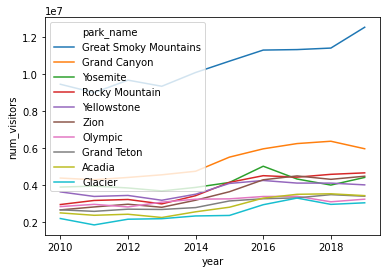

In [363]:
# make a pretty plot
sns.lineplot(x="year", y="num_visitors", hue="park_name", data=top_10_parks_df);

In [367]:
national_park_names = annual_visits_df[annual_visits_df["type"] == "NP"]["park_name"].to_list()
national_park_names[:5]

['Acadia', 'Arches', 'Badlands', 'Big Bend', 'Biscayne']

In [396]:
national_park_code_df = all_park_df.copy()
national_park_code_df["national_park"] = national_park_code_df["name"].apply(lambda x: "NP" if x in national_park_names else "None")
national_park_code_df[national_park_code_df["national_park"] == "NP"]

,abbreviation,name,national_park
0,ABLI,Abraham Lincoln Birthplace,None
1,ACAD,Acadia,NP
2,ADAM,Adams,None
3,AFBG,African Burial Ground,None
4,AGFO,Agate Fossil Beds,None
...,...,...,...
479,YONB,Yorktown Battlefield,None
480,YOSE,Yosemite,NP
481,YUHO,Yucca House,None
482,YUCH,Yukon-Charley Rivers,None


In [419]:
# there are some national parks that end with NP &
add_national_parks = []
for park in annual_visits_df["park_name"].tolist():
    if "NP &" in park:
        add_national_parks.append(park[:-5])
add_national_parks

['Denali',
 'Gates of the Arctic',
 'Glacier Bay',
 'Great Sand Dunes',
 'Katmai',
 'Lake Clark',
 'Wrangell-St. Elias']

In [420]:
add_national_parks += ["North Cascades National Park Service Complex", "Sequoia and Kings Canyon"]
add_national_parks

['Denali',
 'Gates of the Arctic',
 'Glacier Bay',
 'Great Sand Dunes',
 'Katmai',
 'Lake Clark',
 'Wrangell-St. Elias',
 'North Cascades National Park Service Complex',
 'Sequoia and Kings Canyon']

In [422]:
add_abbreviation_list = []
for park in add_national_parks:
    if park in all_park_df["name"].tolist():
        add_abbreviation_list.append([all_park_df[all_park_df["name"] == park]["abbreviation"].values[0], park, "NP"])
add_abbreviation_list

[['DENA', 'Denali', 'NP'],
 ['GAAR', 'Gates of the Arctic', 'NP'],
 ['GLBA', 'Glacier Bay', 'NP'],
 ['GRSA', 'Great Sand Dunes', 'NP'],
 ['KATM', 'Katmai', 'NP'],
 ['LACL', 'Lake Clark', 'NP'],
 ['NCCO', 'North Cascades National Park Service Complex', 'NP'],
 ['SEKI', 'Sequoia and Kings Canyon', 'NP']]

In [ ]:
pd.DataFrame(add_abbreviation_list, columns=national_park_code_df.columns)

In [429]:
national_park_code_df = national_park_code_df.append(pd.DataFrame(add_abbreviation_list, columns=national_park_code_df.columns), ignore_index=True)
national_park_code_df.to_pickle("data/national_park_code_df.pickle")
national_park_code_df

,abbreviation,name,national_park
0,ABLI,Abraham Lincoln Birthplace,None
1,ACAD,Acadia,NP
2,ADAM,Adams,None
3,AFBG,African Burial Ground,None
4,AGFO,Agate Fossil Beds,None
...,...,...,...
487,GRSA,Great Sand Dunes,NP
488,KATM,Katmai,NP
489,LACL,Lake Clark,NP
490,NCCO,North Cascades National Park Service Complex,NP
